In [2]:
# ==============================================================================
# CÉLULA DE SETUP: IMPORTAÇÕES E CARREGAMENTO DOS DADOS PROCESSADOS
# ==============================================================================

# --- Importações de Bibliotecas ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# --- Configurações Globais ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# --- Carregamento dos Dados ---
CAMINHO_DADOS_PROCESSADOS = '../data/processed/dados_consolidados_produtividade_co_2017-2023.csv'
try:
    df_final = pd.read_csv(CAMINHO_DADOS_PROCESSADOS)
    print("Setup concluído. DataFrame 'df_final' carregado com sucesso.")
    print(f"Total de registros: {len(df_final)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo processado não encontrado. Execute o notebook de ETL primeiro.")

Setup concluído. DataFrame 'df_final' carregado com sucesso.
Total de registros: 3026


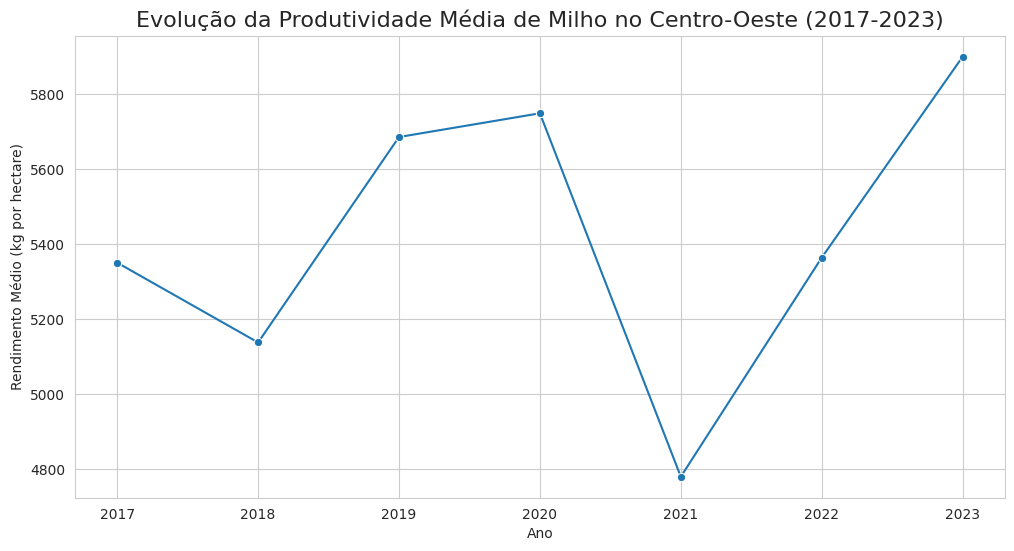

In [3]:
# --- ANÁLISE: Evolução da Produtividade no Tempo ---
produtividade_anual_media = df_final.groupby('ano')['rendimento_medio_kg_ha'].mean()

sns.lineplot(x=produtividade_anual_media.index, y=produtividade_anual_media.values, marker='o')
plt.title('Evolução da Produtividade Média de Milho no Centro-Oeste (2017-2023)', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Rendimento Médio (kg por hectare)')
plt.show()

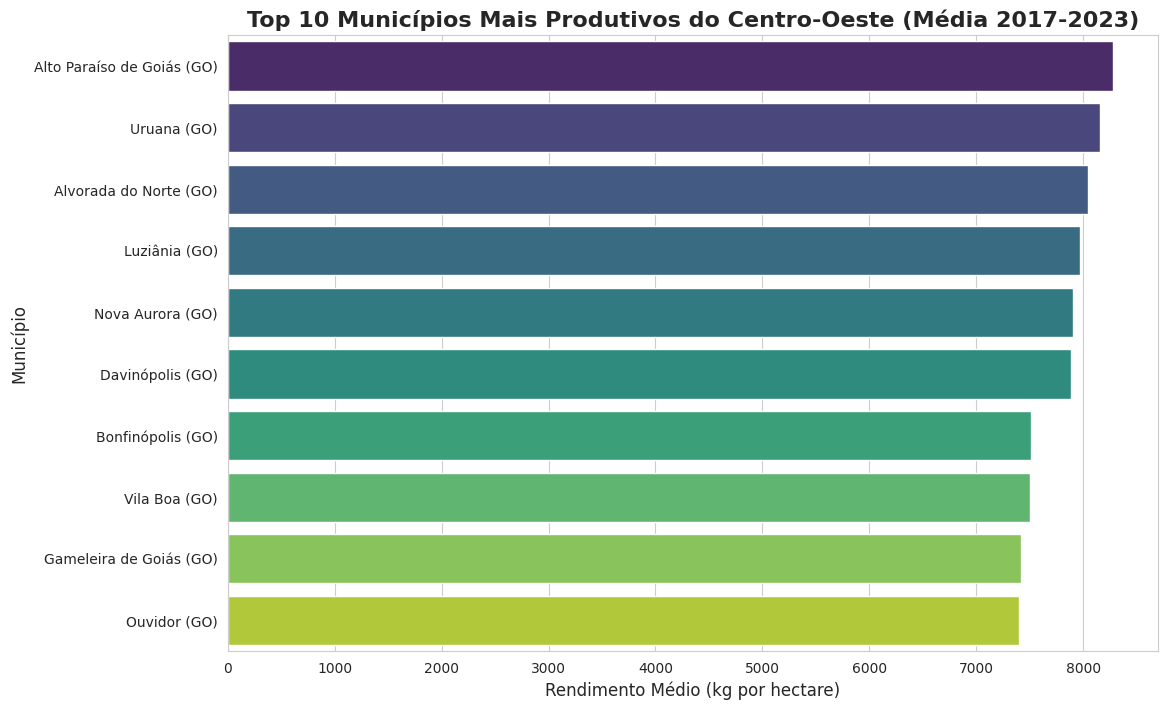

Top 10 Municípios por Produtividade Média (kg/ha):
municipio_nome         uf
Alto Paraíso de Goiás  GO    8280.714286
Uruana                 GO    8157.000000
Alvorada do Norte      GO    8047.142857
Luziânia               GO    7968.142857
Nova Aurora            GO    7903.833333
Davinópolis            GO    7888.000000
Bonfinópolis           GO    7512.714286
Vila Boa               GO    7505.571429
Gameleira de Goiás     GO    7415.285714
Ouvidor                GO    7395.428571
Name: rendimento_medio_kg_ha, dtype: float64


In [4]:
# --- ANÁLISE: Top 10 Municípios Mais Produtivos ---

# Passo 1: Calcular a média de rendimento pra cada município ao longo de todos os anos
# Agrupar por nome e UF e calculamos a média
media_por_municipio = df_final.groupby(['municipio_nome', 'uf'])['rendimento_medio_kg_ha'].mean().sort_values(ascending=False)

# Passo 2: Selecionar os 10 melhores
top_10_municipios = media_por_municipio.head(10)

# Passo 3: Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_municipios.values, y=[f"{nome} ({uf})" for nome, uf in top_10_municipios.index], palette='viridis')

# Adicionar títulos e rótulos
plt.title('Top 10 Municípios Mais Produtivos do Centro-Oeste (Média 2017-2023)', fontsize=16, weight='bold')
plt.xlabel('Rendimento Médio (kg por hectare)', fontsize=12)
plt.ylabel('Município', fontsize=12)
plt.show()

# Passo 4: Exibir os dados em formato de tabela
print("Top 10 Municípios por Produtividade Média (kg/ha):")
print(top_10_municipios)

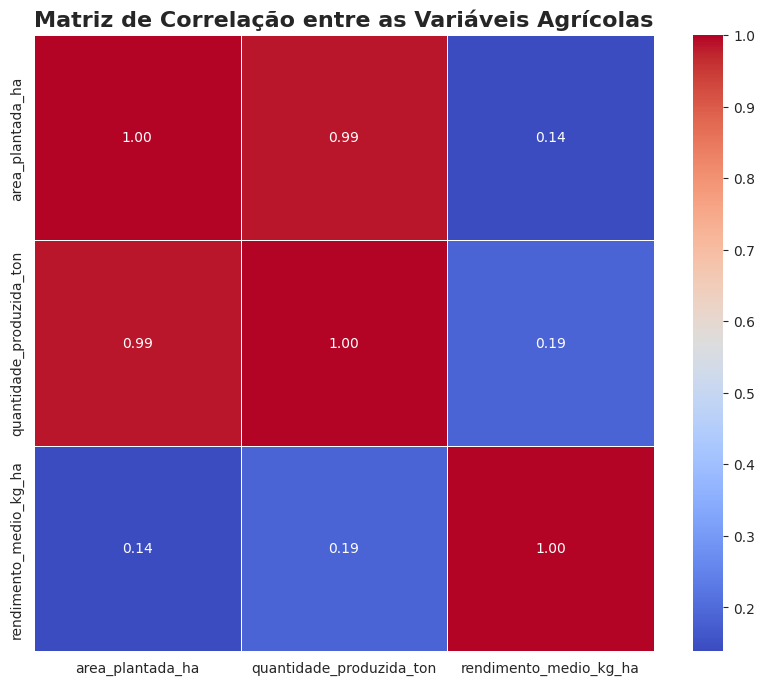


Matriz de Correlação:
                          area_plantada_ha  quantidade_produzida_ton  \
area_plantada_ha                  1.000000                  0.985080   
quantidade_produzida_ton          0.985080                  1.000000   
rendimento_medio_kg_ha            0.138739                  0.188986   

                          rendimento_medio_kg_ha  
area_plantada_ha                        0.138739  
quantidade_produzida_ton                0.188986  
rendimento_medio_kg_ha                  1.000000  


In [5]:
# --- ANÁLISE: Correlação entre as Variáveis Numéricas ---

# Selecionar apenas as colunas numéricas que queremos correlacionar
colunas_numericas = ['area_plantada_ha', 'quantidade_produzida_ton', 'rendimento_medio_kg_ha']
df_numerico = df_final[colunas_numericas]

# Calcula a matriz de correlação
matriz_correlacao = df_numerico.corr()

# Cria o heatmap pra visualizar a matriz
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, 
            annot=True,     # Mostra os números dentro de cada célula
            cmap='coolwarm',# O esquema das cores (quente pra positivo, frio pra negativo) melhor ao pior
            fmt=".2f",      # Formata os números pra duas casas decimais
            linewidths=.5)  # Adiciona linhas entre as células

plt.title('Matriz de Correlação entre as Variáveis Agrícolas', fontsize=16, weight='bold')
plt.show()

# Exibir a matriz como tabela pra referência
print("\nMatriz de Correlação:")
print(matriz_correlacao)

In [6]:
# --- ENRIQUECIMENTO: Adicionando Coordenadas Geográficas ---

print("Iniciando o enriquecimento do DataFrame com coordenadas...")

# Etapa 1: Carregar o dataset externo com as coordenadas dos municípios brasileiros
url_municipios = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv'
df_coords = pd.read_csv(url_municipios)

# Etapa 2: Preparar os DataFrames para a unificação (merge)
# Seleciona apenas as colunas que interessa do dataset de coordenadas
df_coords_essencial = df_coords[['codigo_ibge', 'latitude', 'longitude']].copy()

# O código do IBGE no df_coords tem 7 dígitos. O 'cod_municipio' é um número inteiro.
# Para garantir a correspondência, vamos usar o código do IBGE de 7 dígitos.
# A coluna 'codigo_ibge' no df_coords é a  chave de correspondência.
df_enriquecido = pd.merge(
    df_final,
    df_coords_essencial,
    left_on='cod_municipio',  # Coluna do df_final
    right_on='codigo_ibge', # Coluna do df_coords
    how='left'                # 'left' ´é um join para manter todas as linhas do  df_final
)

# Etapa 3: Verificaçao e limpeza 
# remover a coluna 'codigo_ibge' que veio do merge, pois é redundante
df_enriquecido.drop('codigo_ibge', axis=1, inplace=True) #  

# Verificar se há algum município para o qual não encontramos coordenadas
municipios_sem_coords = df_enriquecido[df_enriquecido['latitude'].isnull()]
if not municipios_sem_coords.empty:
    print("\nAtenção: Os seguintes municípios não tiveram coordenadas encontradas:")
    print(municipios_sem_coords['municipio_nome'].unique())
else:
    print("\nSucesso! Todos os municípios foram enriquecidos com coordenadas.")

# Exibir informações do novo DataFrame e uma amostra
print("\nInformações do DataFrame Enriquecido:")
df_enriquecido.info()

print("\nAmostra dos Dados Finais com Coordenadas:")
df_enriquecido.head()

Iniciando o enriquecimento do DataFrame com coordenadas...

Sucesso! Todos os municípios foram enriquecidos com coordenadas.

Informações do DataFrame Enriquecido:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cod_municipio             3026 non-null   int64  
 1   municipio_nome            3026 non-null   object 
 2   uf                        3026 non-null   object 
 3   ano                       3026 non-null   int64  
 4   area_plantada_ha          3026 non-null   float64
 5   quantidade_produzida_ton  3025 non-null   float64
 6   rendimento_medio_kg_ha    3025 non-null   float64
 7   latitude                  3026 non-null   float64
 8   longitude                 3026 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 212.9+ KB

Amostra dos Dados Finais com Coordenadas:


,cod_municipio,municipio_nome,uf,ano,area_plantada_ha,quantidade_produzida_ton,rendimento_medio_kg_ha,latitude,longitude
0,5000203,Água Clara,MS,2021,342.0,1104.0,4800.0,-20.4452,-52.8790
1,5000203,Água Clara,MS,2022,120.0,598.0,4983.0,-20.4452,-52.8790
2,5000252,Alcinópolis,MS,2017,4620.0,30780.0,6662.0,-18.3255,-53.7042
3,5000252,Alcinópolis,MS,2018,4680.0,28620.0,6115.0,-18.3255,-53.7042
4,5000252,Alcinópolis,MS,2019,6824.0,41784.0,6123.0,-18.3255,-53.7042


In [7]:
import requests
import time
import numpy as np

def buscar_dados_climaticos(linha_dataframe):
    """
    (VERSÃO FINAL E POLIDA) Busca dados da NASA, calcula a média anual e ARREDONDA o resultado.
    """
    lat = linha_dataframe['latitude']
    lon = linha_dataframe['longitude']
    ano = int(linha_dataframe['ano'])
    
    data_inicio = f"{ano}0101"
    data_fim = f"{ano}1231"
    
    # Este print foi removido para não poluir a saída do loop grande
    # print(f"Buscando dados para o ano {ano} nas coordenadas ({lat:.2f}, {lon:.2f})...")
    
    parametros = "PRECTOTCORR,T2M_MAX,T2M_MIN"
    url_base = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parametros, "community": "AG", "longitude": lon,
        "latitude": lat, "start": data_inicio, "end": data_fim, "format": "JSON"
    }
    
    try:
        response = requests.get(url_base, params=params, timeout=60)
        response.raise_for_status()
        dados_json = response.json()
        
        def calcular_media(dados_dict):
            if not dados_dict: return None
            valores_validos = [v for v in dados_dict.values() if v > -900]
            return np.mean(valores_validos) if valores_validos else None

        preci_media = calcular_media(dados_json.get('properties', {}).get('parameter', {}).get('PRECTOTCORR', {}))
        temp_max_media = calcular_media(dados_json.get('properties', {}).get('parameter', {}).get('T2M_MAX', {}))
        temp_min_media = calcular_media(dados_json.get('properties', {}).get('parameter', {}).get('T2M_MIN', {}))
        
        # --- AJUSTE DE ARREDONDAMENTO AQUI ---
        # Se o valor não for nulo, arredonda para 2 casas decimais
        if preci_media is not None: preci_media = round(preci_media, 2)
        if temp_max_media is not None: temp_max_media = round(temp_max_media, 2)
        if temp_min_media is not None: temp_min_media = round(temp_min_media, 2)
            
        return preci_media, temp_max_media, temp_min_media
        
    except requests.exceptions.RequestException as e:
        # Em um loop grande, é melhor não poluir a tela com erros, apenas retornar nulos
        # print(f"ERRO na requisição: {e}")
        return None, None, None

# --- TESTE RÁPIDO (Opcional, mas recomendado antes do loop grande) ---

linha_teste = df_enriquecido.iloc[0]
chuva, temp_max, temp_min = buscar_dados_climaticos(linha_teste)

print("\n--- Resultado do Teste com Arredondamento ---")
print(f"Município: {linha_teste['municipio_nome']} ({linha_teste['uf']})")
print(f"Ano: {int(linha_teste['ano'])}")
print(f"Precipitação Média Anual (mm/dia): {chuva}")
print(f"Temperatura Máxima Média Anual (°C): {temp_max}")
print(f"Temperatura Mínima Média Anual (°C): {temp_min}")


--- Resultado do Teste com Arredondamento ---
Município: Água Clara (MS)
Ano: 2021
Precipitação Média Anual (mm/dia): 2.19
Temperatura Máxima Média Anual (°C): 32.72
Temperatura Mínima Média Anual (°C): 19.08


In [8]:
from tqdm import tqdm
import time

# --- APLICAÇÃO DA FUNÇÃO A TODO O DATAFRAME ---

lista_chuvas, lista_temps_max, lista_temps_min = [], [], []

print(f"Iniciando a coleta de dados climáticos para {len(df_enriquecido)} registros. Isso pode demorar...")

for indice, linha in tqdm(df_enriquecido.iterrows(), total=len(df_enriquecido)):
    chuva, temp_max, temp_min = buscar_dados_climaticos(linha)
    
    lista_chuvas.append(chuva)
    lista_temps_max.append(temp_max)
    lista_temps_min.append(temp_min)
    
    time.sleep(1) # Delay para não sobrecarregar a API

print("\nColeta de dados concluída!")

df_final_com_clima = df_enriquecido.copy()
df_final_com_clima['precipitacao_media_anual'] = lista_chuvas
df_final_com_clima['temp_max_media_anual'] = lista_temps_max
df_final_com_clima['temp_min_media_anual'] = lista_temps_min

print("\nInformações do DataFrame final com dados climáticos:")
df_final_com_clima.info()

print("\nAmostra do DataFrame final:")
df_final_com_clima.head()

Iniciando a coleta de dados climáticos para 3026 registros. Isso pode demorar...


100%|██████████| 3026/3026 [4:00:34<00:00,  4.77s/it]  


Coleta de dados concluída!

Informações do DataFrame final com dados climáticos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cod_municipio             3026 non-null   int64  
 1   municipio_nome            3026 non-null   object 
 2   uf                        3026 non-null   object 
 3   ano                       3026 non-null   int64  
 4   area_plantada_ha          3026 non-null   float64
 5   quantidade_produzida_ton  3025 non-null   float64
 6   rendimento_medio_kg_ha    3025 non-null   float64
 7   latitude                  3026 non-null   float64
 8   longitude                 3026 non-null   float64
 9   precipitacao_media_anual  3014 non-null   float64
 10  temp_max_media_anual      3014 non-null   float64
 11  temp_min_media_anual      3014 non-null   float64
dtypes: float64(8), int64(2), object(2)
m

,cod_municipio,municipio_nome,uf,ano,area_plantada_ha,quantidade_produzida_ton,rendimento_medio_kg_ha,latitude,longitude,precipitacao_media_anual,temp_max_media_anual,temp_min_media_anual
0,5000203,Água Clara,MS,2021,342.0,1104.0,4800.0,-20.4452,-52.8790,2.19,32.72,19.08
1,5000203,Água Clara,MS,2022,120.0,598.0,4983.0,-20.4452,-52.8790,3.24,31.07,18.24
2,5000252,Alcinópolis,MS,2017,4620.0,30780.0,6662.0,-18.3255,-53.7042,2.25,32.84,20.41
3,5000252,Alcinópolis,MS,2018,4680.0,28620.0,6115.0,-18.3255,-53.7042,2.85,32.47,20.26
4,5000252,Alcinópolis,MS,2019,6824.0,41784.0,6123.0,-18.3255,-53.7042,2.93,32.76,20.63


In [11]:
# Salvar o DataFrame final com todos os dados (IBGE + Coordenadas + Clima)
caminho_final_enriquecido = '../data/processed/dataset_completo_com_clima.csv'

df_final_com_clima.to_csv(caminho_final_enriquecido, index=False)

print(f"Dataset final e enriquecido salvo com sucesso em: {caminho_final_enriquecido}")

Dataset final e enriquecido salvo com sucesso em: ../data/processed/dataset_completo_com_clima.csv


In [12]:
# --- PRÉ-PROCESSAMENTO: Análise de Valores em Falta ---

print("Contagem de valores nulos (NaN) por coluna:")
print(df_final_com_clima.isnull().sum())

# Calcular a percentagem de dados em falta nas colunas de clima
porcentagem_faltante = df_final_com_clima[['precipitacao_media_anual', 'temp_max_media_anual', 'temp_min_media_anual']].isnull().sum() / len(df_final_com_clima) * 100
print("\nPercentagem de dados climáticos em falta:")
print(porcentagem_faltante)

Contagem de valores nulos (NaN) por coluna:
cod_municipio                0
municipio_nome               0
uf                           0
ano                          0
area_plantada_ha             0
quantidade_produzida_ton     1
rendimento_medio_kg_ha       1
latitude                     0
longitude                    0
precipitacao_media_anual    12
temp_max_media_anual        12
temp_min_media_anual        12
dtype: int64

Percentagem de dados climáticos em falta:
precipitacao_media_anual    0.396563
temp_max_media_anual        0.396563
temp_min_media_anual        0.396563
dtype: float64


In [13]:
# --- PRÉ-PROCESSAMENTO: Tratamento de Valores em Falta ---

print(f"Número de registos antes da limpeza: {len(df_final_com_clima)}")

# Remover todas as linhas que contenham QUALQUER valor nulo (NaN)
df_modelo = df_final_com_clima.dropna()

print(f"Número de registos após a limpeza: {len(df_modelo)}")
print("\nVerificando se ainda existem valores nulos:")
print(df_modelo.isnull().sum())

Número de registos antes da limpeza: 3026
Número de registos após a limpeza: 3013

Verificando se ainda existem valores nulos:
cod_municipio               0
municipio_nome              0
uf                          0
ano                         0
area_plantada_ha            0
quantidade_produzida_ton    0
rendimento_medio_kg_ha      0
latitude                    0
longitude                   0
precipitacao_media_anual    0
temp_max_media_anual        0
temp_min_media_anual        0
dtype: int64
